# Monte Carlo Simulation of Scintillator and PMT for AESOP-Lite

### By Liam Branch and Robert Johnson

In [79]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import random

### Links
- [Simple ray tracing](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)
-[2D intersection circle](https://www.geometrictools.com/Documentation/IntersectionLine2Circle2.pdf)
- [3D intersection sphere](https://math.stackexchange.com/questions/2247498/intersection-of-ray-with-circle-in-3d-subject-to-endpoint-and-orientation-constr)
- [3D ray sphere v2](https://math.stackexchange.com/questions/70196/whats-the-distance-between-a-ray-and-a-sphere)
- [Chords on a circle](https://en.wikipedia.org/wiki/Chord_(geometry))
- [Fresnel equations](https://en.wikipedia.org/wiki/Fresnel_equations)

PDF Datasheets
- [Hamamatasu](hamamatsu.com/content/dam/hamamatsu-photonics/sites/documents/99_SALES_LIBRARY/etd/R2083_R3377_TPMH1227E.pdf)

In [80]:
# Constants
c = 0.0299792 # Speed of Light in cm / ps
# Measurements made on a Zoom call with James on March 6th,2022
# xPMT1=8.*cos(-45)*2.54
# yPMT1=8.*sin(-45)*2.54
xPMT1=8.*np.cos(np.rad(-45))*2.54
yPMT1=8.*np.sin(np.rad(-45))*2.54
# x2PMT1=8.*cos(-53.72)*2.54 # For test
# y2PMT1=8.*sin(-53.72)*2.54 # For test
#
# xPMT4=9.5*cos(110)*2.54
# yPMT4=9.5*sin(110)*2.54
# Estimated by Pierre-Simon on March 7th, 2002
# xPMT3=7.*cos(8))*2.54
# yPMT3=7.*sin(80)*2.54
# xPMTG=7.*cos(100)*2.54
# yPMTG=7.*sin(100)*2.54

# The radii of the scintillators are, in cm:
# Rad1=13
# Rad3=3.5
# RadGi=3.5
# RadGo=13.5
# Rad4=18

In [81]:
scint_radius = 13. # cm
scint_width = 0.5 #
width_pmt_window = 4 # cm
length_pmt_window = 1 #cm
width = width_pmt_window/2
length = length_pmt_window
theta_lim = np.arcsin(width/scint_radius)
# Position of PMT
x = width/np.tan(theta_lim) # thetax_0
y = -width
# Main Scintillator angles
theta_scint = np.linspace(theta_lim,2*np.pi-theta_lim, 100)

### Particle path creator
I chose for the particle to appear first 2cm above the scintillator and then max angle of 40 degrees

```
# PSEUDOCODE
    # Generate random position in circle and random direction in allowed cone
    # Walk
    # while z of particle > lowest z point of T4
    #     if point is outside of scintillator
    #          then step to next scintillator boundary
    #     for each scintillator:
    #          if point is insde of scintillator_i
    #                walk mean free path length and store if still within scintillator_i
```

In [82]:
def particle_path(t, phi_range_deg, T1_z, T1_width, T4_z, T4_width, T1_radius, mean_free_path, photons_per_E):
    theta = random.uniform(0,2*np.pi)                                                 # random theta in circle above T1
    phi = random.uniform(np.pi-phi_range_deg*np.pi/180/2,np.pi+phi_range_deg*np.pi/180/2) # phi angle pointing in -k given phi range
    maxdist = np.random.random()*T1_radius/2                                          # half the radius of T1
    o = np.float64((maxdist*np.cos(theta), maxdist*np.sin(theta), T1_z+T1_width+2))   # x, y, top of T1_z+2
    u = np.array((np.cos(theta)*np.sin(phi),np.sin(theta)*np.sin(phi),np.cos(phi)),dtype=np.float64)
    print(f"u=({u[0]:.2f},{u[1]:.2f},{u[2]:.2f})")
    photons = [0]                          # begin photon array
    points = [o]                           # current point 
    times = [t]                            # current t 
    z = points[-1][2]                      # current z 
    z_1 = (z+mean_free_path*u[2]).round(2) # next z step
    inside_scint = False
    while z_1 >= T4_z:
        if not inside_scint:
            distT1 = np.abs((T1_z+T1_width - z)/u[2])
            distT4 = np.abs((T4_z+T4_width - z)/u[2])
            dist = distT4 if z_1 < T1_z else distT1
#             print(f"t={t:.2f} dist={dist:.2f} distT1={distT1:.2f}, distT4={distT4:.2f} ")
            t +=  dist/c # calculate time in ps passed
            times.append(t)
            points.append(points[-1] + dist*u)
            photons.append(np.random.poisson(photons_per_E))
            z = points[-1][2]
            z_1 = (z+mean_free_path*u[2]).round(2)
        for Tbottom,Ttop in [(T1_z,T1_z+T1_width),(T4_z,T4_z+T4_width)]:
            inside_scint = (z_1 <= (Ttop)) & (z_1 >= Tbottom)
            if inside_scint:
                while inside_scint:
                    t +=  mean_free_path/c
                    times.append(t)
                    points.append(points[-1] + mean_free_path*u)
                    photons.append(np.random.poisson(photons_per_E))
                    z = points[-1][2]
                    z_1 = (z+mean_free_path*u[2]).round(2)
                    inside_scint = (z_1 <= (Ttop)) & (z_1 >= Tbottom)
#                     print(f"t={t:.2f} o_z {z:.2f}")
    print(f"time elapsed in scintillators: {np.abs(times[1]-times[-1]):.2f}ps total scintillation points: {len(points[1:])}")
    return np.array(times, dtype=np.float64)[1:], np.array(points, dtype=np.float64)[1:], np.array(photons[1:], dtype=np.float64)

In [83]:
times, points, photons = particle_path(t=2, phi_range_deg=40, T1_z=2.5, T1_width=1, T4_z=0, T4_width=1, T1_radius=13, mean_free_path=0.05, photons_per_E=10)

u=(-0.15,-0.20,-0.97)
time elapsed in scintillators: 119.37ps total scintillation points: 42


<IPython.core.display.Javascript object>


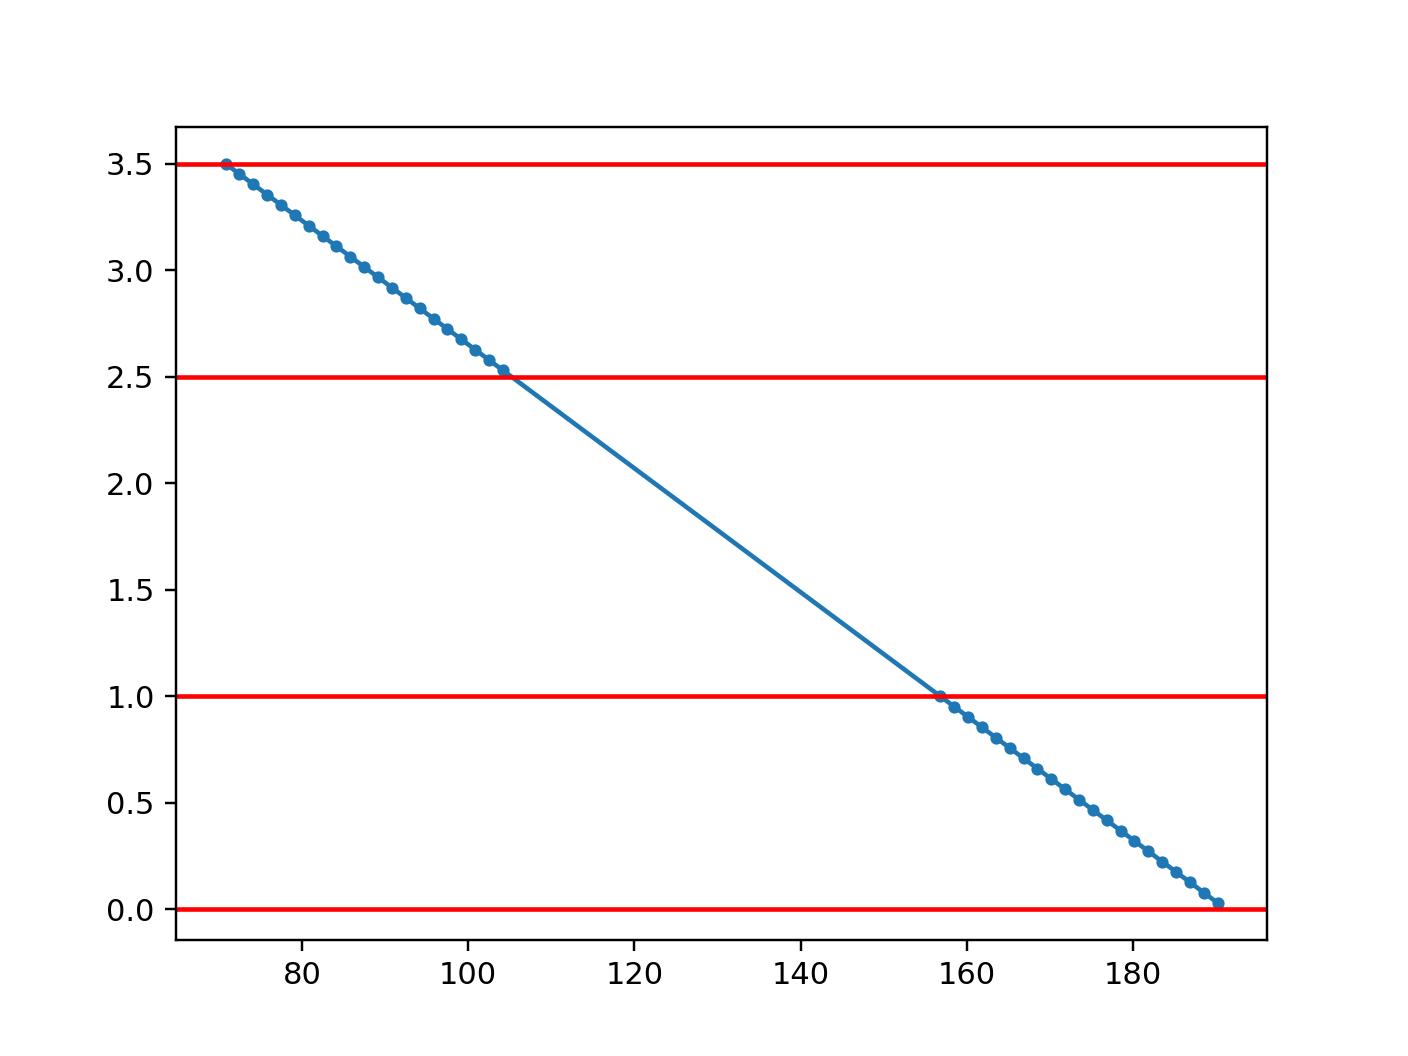

In [84]:
plt.plot(times,points[:,2],marker='.')
plt.axhline(0,color='red')
plt.axhline(1,color='red')
plt.axhline(2.5,color='red')
plt.axhline(2.5+1,color='red')
plt.show()

### Photon path tracker

**Geometries**

In [87]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 20)
    theta = np.linspace(0, 2*np.pi, 20)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid
def sphere():   
    phi = np.linspace(1,10,100)
    Phi, Theta = np.meshgrid(phi, phi)
    x = np.cos(Phi)*np.sin(Theta)
    y = np.sin(Phi)*np.sin(Theta)
    z = np.cos(Theta)
    return x,y,z

### Light Guide Building

How about if we build the tube as a square with a condition past a plane to continute to reflect to the PMT

In [207]:
def light_guide(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 100)
    theta = np.linspace(0, 2*np.pi, 100)
    theta_grid, z_grid = np.meshgrid(theta[theta <= (np.pi/2)], z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid
def light_guide_cuboid(center, size, border_radius):
    """
   Create a data array for cuboid plotting.
   ============= ================================================
   Argument      Description
   ============= ================================================
   center        center of the cuboid, triple
   size          size of the cuboid, triple, (x_length,y_width,z_height)
   :type size: tuple, numpy.array, list
   :param size: size of the cuboid, triple, (x_length,y_width,z_height)
   :type center: tuple, numpy.array, list
   :param center: center of the cuboid, triple, (x,y,z)
    """
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = np.array([[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]])  # x coordinate of points in inside surface
    y = np.array([[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]])    # y coordinate of points in inside surface
    z = np.array([[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]])                # z coordinate of points in inside surface
    return x, y, z
def light_sphere(border_point, height_z, border_radius): 
    z = np.linspace(0, height_z, 20)
    theta = np.linspace(0, np.pi/2, 20)
    theta_grid, z = np.meshgrid(theta, z)
    x = border_radius*np.cos(theta_grid) + border_point[0]-border_radius
    y = border_radius*np.sin(theta_grid) + border_point[1]-border_radius
    return x,y,z

<IPython.core.display.Javascript object>


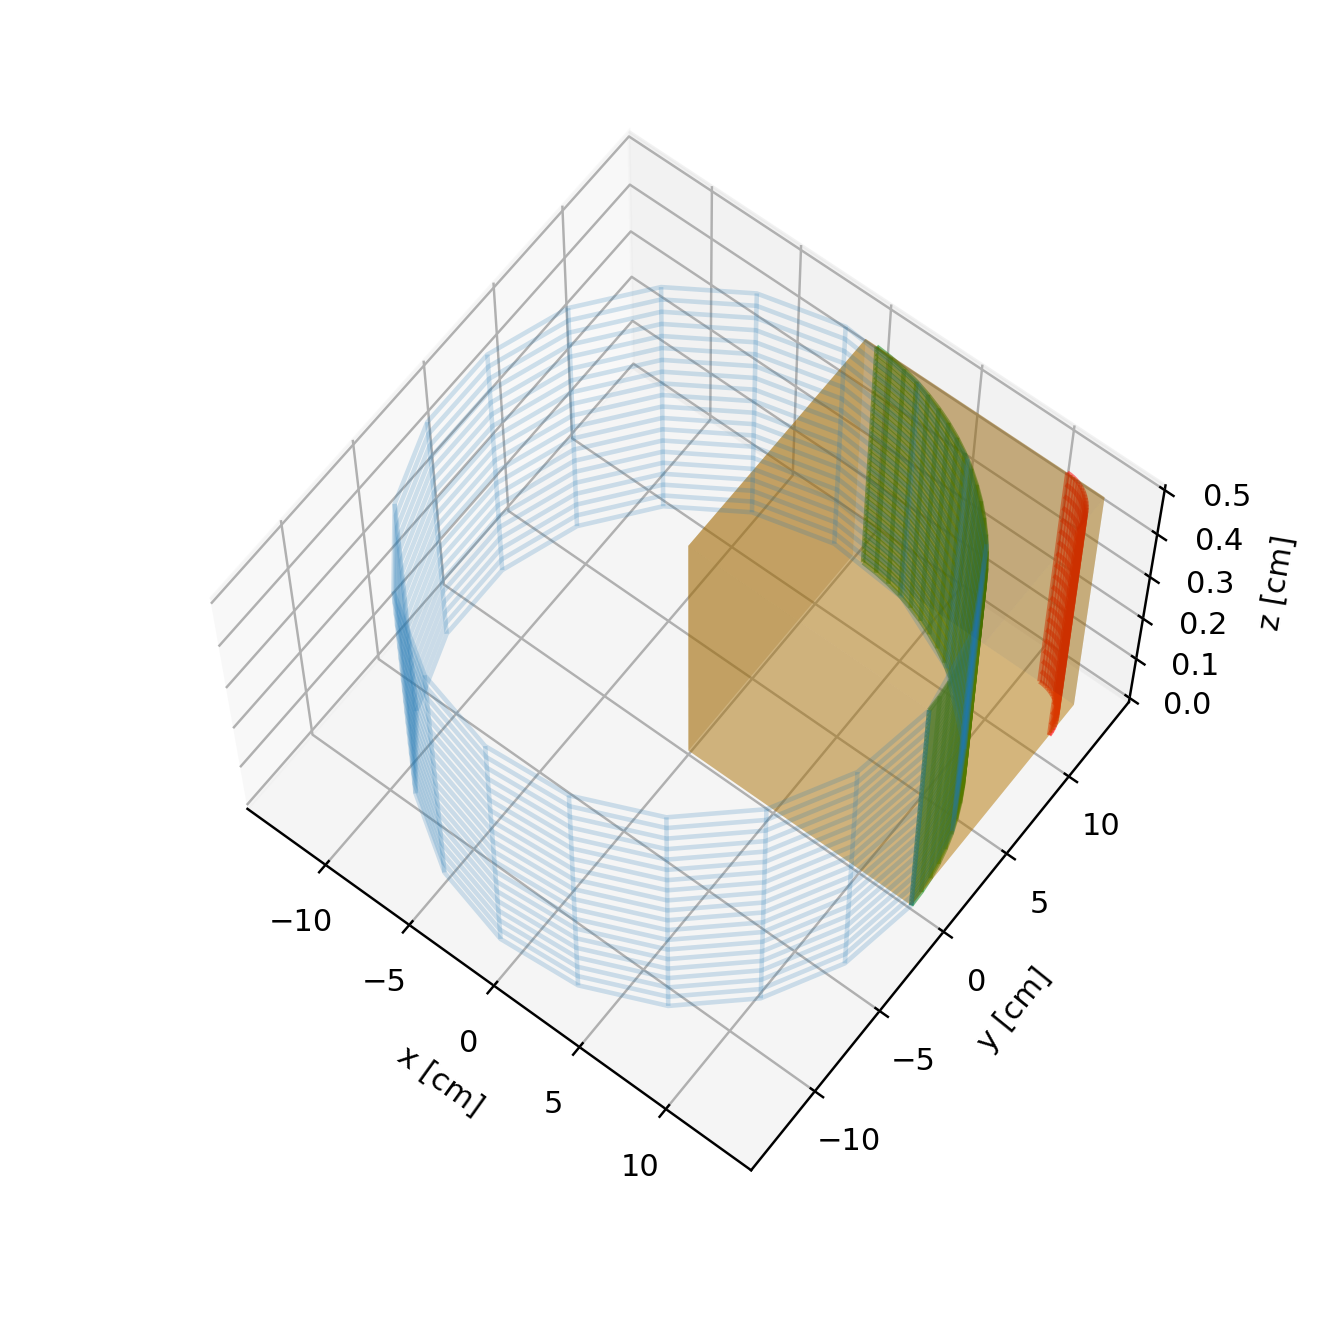

In [209]:
# Light tube building
fig1 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111, projection='3d')
X, Y, Z = data_for_cylinder_along_z(0,0,scint_radius,0.5)
LX, LY, LZ = light_guide(0,0,scint_radius,0.5)
xyz = (scint_radius/2,scint_radius/2,scint_width/2)
hwd = np.array([scint_radius, scint_radius, scint_width])
SX, SY, SZ = light_guide_cuboid(xyz, hwd, 1)
xyz = np.array([scint_radius, scint_radius])
SphX, SphY, SphZ = light_sphere(xyz, height_z=scint_width, border_radius=scint_width*4)
ax1.plot_wireframe(X, Y, Z, alpha=0.2)
ax1.plot_wireframe(LX, LY, LZ, alpha=0.5, color='green')
ax1.plot_surface(SX, SY, SZ, alpha=0.2, color='orange')
ax1.plot_wireframe(SphX, SphY, SphZ, alpha=0.5, color='red')
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')
ax1.set_zlabel('z [cm]')
# ax1.set_xlim([-13,13])
# ax1.set_ylim([-13,13])
# ax1.set_zlim([-0.5,1.5])
plt.show()

$$ R_s = \Bigg\vert\frac{n_1\cos\theta_i - n_2\cos\theta_t}{n_1\cos\theta_i+n_2\cos\theta_t}\Bigg\vert^2 = 
\Bigg\vert \frac{n_1\cos\theta_i - n_2\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2}}{n_1\cos\theta_i + n_2\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2}}\Bigg\vert^2
$$
$$ R_p = \Bigg\vert\frac{n_1\cos\theta_t - n_2\cos\theta_i}{n_1\cos\theta_t+n_2\cos\theta_i}\Bigg\vert^2 = 
\Bigg\vert \frac{n_1\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2} - n_2\cos\theta_i}{n_1\sqrt{1-\Big(\frac{n_1}{n_2}\sin\theta_i\Big)^2} + n_2\cos\theta_i}\Bigg\vert^2
$$

$$ \sin\theta = \frac{\lVert \vec u \times \vec n \lVert}{\lVert \vec u \lVert \lVert \vec n \lVert}$$

In [85]:
def normalize(x):
    x /= np.linalg.norm(x)
    return x
def mag(x):
    return np.linalg.norm(x)

In [86]:
def distance_solver(u, o, center, radius, plane_z, border_radius):
    dcircle = distance_circle(u,o,center,radius)
    dplane_z = distance_plane(u,o,plane_z)
    if (o[0] > 0) & (o[1] > 0) & ((o[0]**2+o[1]**2) >= radius**2):
        return distance_light_guide(u, o, center, radius, plane_z, border_radius)
    else:
        return dplane_z if dcircle > dplane_z else dcircle
def distance_light_guide(u, o, center, radius, plane_z, border_radius):
    dplanex = distance_plane(u,o,radius,dim=0) # checks x
    dplaney = distance_plane(u,o,radius,dim=1) # checks x
    dplanez = distance_plane(u,o,plane_z,dim=2) # check z
    dborder = distance_circle(u,o, (radius-border_radius,radius-border_radius)
    if o[0] == radius:
        
def distance_circle(u, o, center, radius): #3d directional vector, 3d point, center of scintillator, radius of scintillator
    P = o
    D = u*-1 if np.dot(u,P) < 0 else u
    C = center
    R = radius
    bigDelta = P-C
    # t = -D . ∆ ± √(D . ∆)^2 - |D|^2(|∆|^2 - R^2)
    #     over |D|^2
    magDsq = mag(D)**2
    magDeltasq = mag(bigDelta)**2
    DdotDelta = np.dot(D,bigDelta)
    sqrt_term = np.sqrt(DdotDelta**2 - magDsq * (magDeltasq - R**2))/magDsq
    b_term = -DdotDelta/magDsq
    rootA = b_term - sqrt_term
    rootB = b_term + sqrt_term
    return np.abs(rootA) if (rootA < 0) & (np.dot(u,P) < 0) else np.abs(rootB)
#     return -rootA if (rootA < 0) & (np.dot(u,P) < 0) else (-rootB if np.dot(u,P) < 0 else rootB)
def distance_plane(u, o, plane, dim=2): #3d directional vector, 3d point, z positions of planes bottom and top
    P = o
    z_plane = plane[0] if u[dim] < 0 else plane[1] # make sure direction matches location of plane 
    return np.abs((z_plane - P[dim])/u[dim])

In [10]:
def photon_interaction(u, n, E):
    u_i = u
    u_r = u - 2*np.dot(u, n)*n # u_new = u - 2 (u . n)*n
    # CONDITION n_1 <= n_2
    n_1 = 1.000293 # 1.85 for NaI
    n_2 = 1.5 # Sample index of refraction of air
    v = u*-1 if np.dot(u,n) < 0 else u
    theta = np.arcsin(mag(np.cross(v,n))/(mag(u)*mag(n)))
#     theta = np.arccos(mag(np.dot(v,n))/(mag(u)*mag(n)))
    inside_sqrt = ((n_1/n_2)*np.sin(theta))**2
    sqrt_term = np.sqrt(1 - inside_sqrt)
    Rs = np.abs((n_1*np.cos(theta) - n_2*sqrt_term)/(n_1*np.cos(theta) + n_2*sqrt_term))**2
    Rp = np.abs((n_1*sqrt_term - n_2*np.cos(theta))/(n_1*sqrt_term + n_2*np.cos(theta)))**2
    E *= (Rs+Rp)/2 # energy loss n of photon using Reflectance
    return u_r, E

def scintillator_monte_carlo(o, x_pmt, E, scint_radius, scint_plane, N_max, dt):
    print(f"Starting position (x_0,y_0,z_0) = ({o[0]:.2f},{o[1]:.2f},{o[2]:.2f})")
    track_history = np.zeros((N_max+1,7))         # x, y history of Photon
    theta = random.uniform(0,2*np.pi)           # first theta direction of photon
    phi = random.uniform(0,np.pi)               # first phi   direction of photon
    u = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]) # first direction unit vector
    track_history[0,:] = [o[0],o[1],o[2],u[0],u[1],u[2],E]
    i = 1
    while (i < N_max+1) & (o[0] < x_pmt) & (E > 0.1):
        ds = distance_solver(u, o, np.zeros(3),scint_radius, scint_plane)
        x, y, z = o+ds*u
        dt = np.abs(ds)/c if np.abs(ds)>1e-9 else float('inf')  # time taken in ps traveling in direction theta
        print(f"step {i}: ds={ds:.2f}cm dt={dt:.2f}ps E={E:.2f} xyz =({x:.2f},{y:.2f},{z:.2f}) u=({u[0]:.2f},{u[1]:.2f},{u[2]:.2f})")
        o = np.array([x, y, np.abs(z) if np.abs(z-scint_plane).any() < 1e-5 else z])
        if z == scint_plane[0]:
            n = np.array([0,0,+1])
        elif z == scint_plane[1]:
            n = np.array([0,0,-1])
        else:
            n = normalize(o-np.zeros(3))
        u, E = photon_interaction(u, n, E)
        track_history[i] = [x,y,z,u[0],u[1],u[2],E]
        i+=1
    if i < N_max+1:
        track_history = track_history[:i,:]
        
    print(f"DONE E left={E}")
    return track_history

<IPython.core.display.Javascript object>


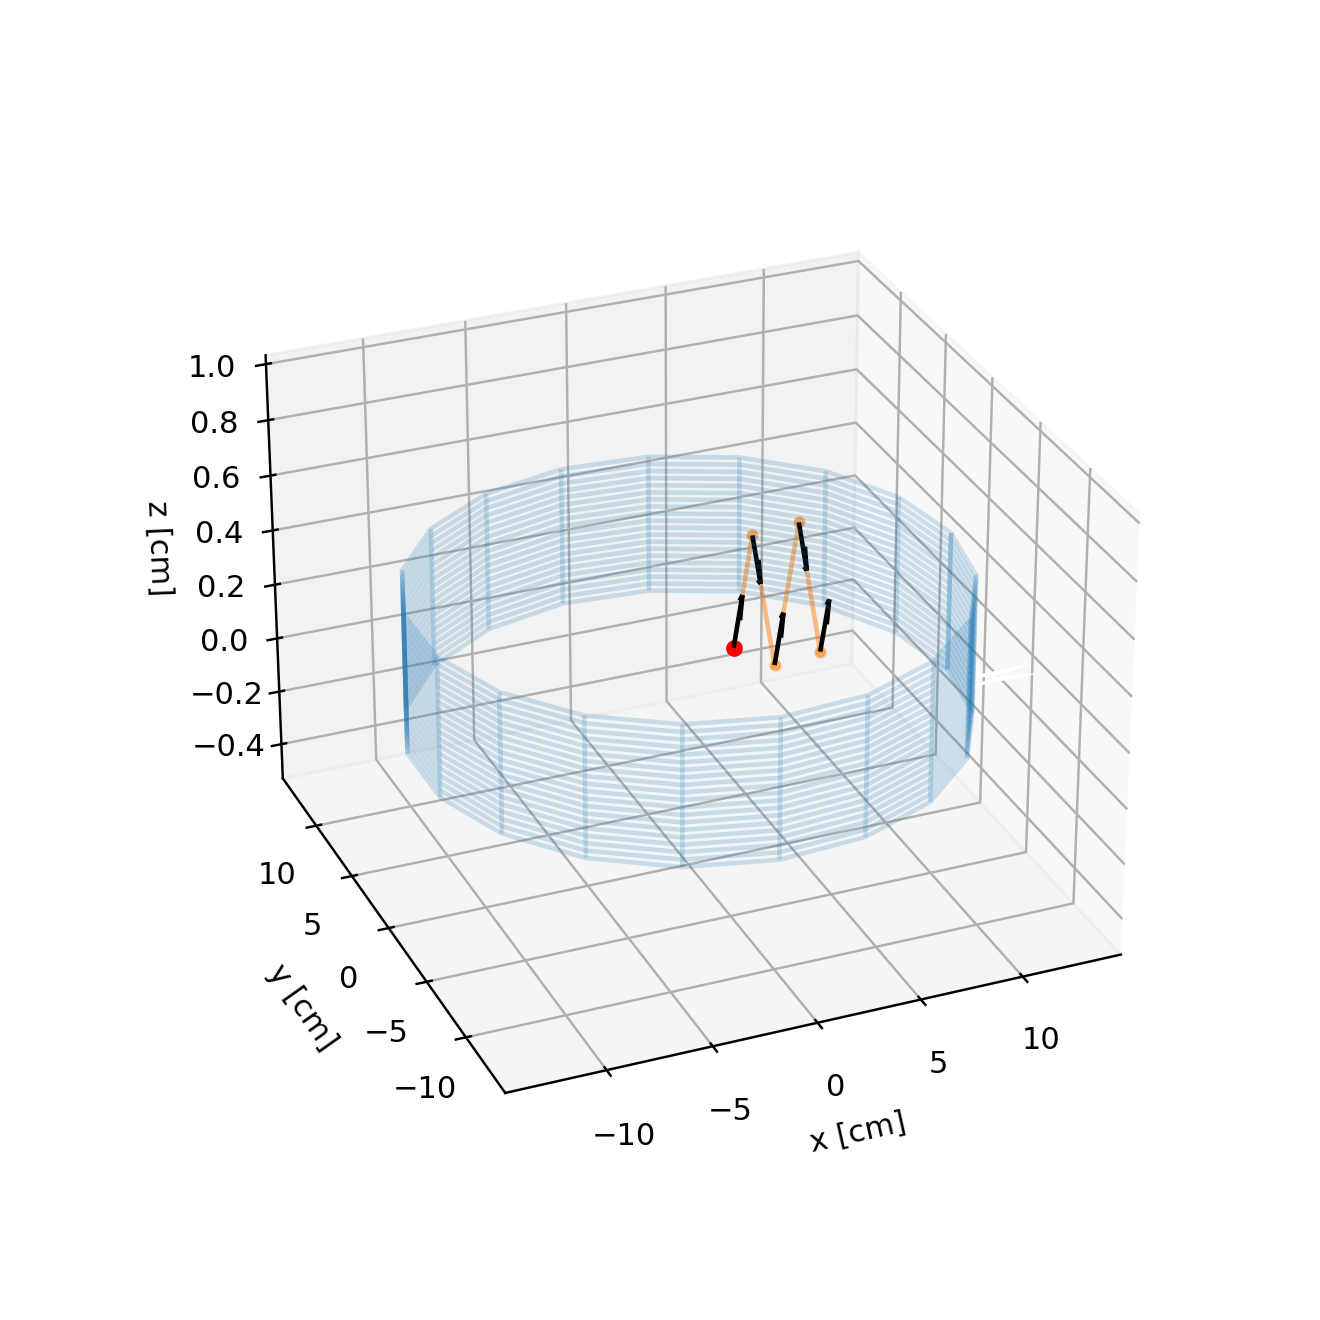

Starting position (x_0,y_0,z_0) = (3.55,3.12,0.11)
step 1: ds=1.06cm dt=35.35ps E=100.00 xyz =(4.52,3.27,0.50) u=(0.92,0.14,0.37)
step 2: ds=1.35cm dt=45.14ps E=15.12 xyz =(5.76,3.46,0.00) u=(0.92,0.14,-0.37)
step 3: ds=1.35cm dt=45.14ps E=2.29 xyz =(7.00,3.65,0.50) u=(0.92,0.14,0.37)
step 4: ds=1.35cm dt=45.14ps E=0.35 xyz =(8.25,3.85,0.00) u=(0.92,0.14,-0.37)
DONE E left=0.052240854670186944


In [31]:
# Plot
fig0 = plt.figure(figsize=(6,6))
ax0 = fig0.add_subplot(111, projection='3d')
# ax0.plot(scint_radius*np.cos(theta_scint), scint_radius*np.sin(theta_scint), 0)
X, Y, Z = data_for_cylinder_along_z(0,0,scint_radius,0.5)
ax0.plot_wireframe(X, Y, Z, alpha=0.2)
r = random.uniform(0,2*np.pi)
maxdist = np.random.random()*scint_radius
random_track = (maxdist*np.cos(r), maxdist*np.sin(r), np.random.random()*scint_width) # x, y
ax0.scatter(random_track[0],random_track[1],random_track[2], color='red', marker='o')
# pmt_window = plt.Rectangle((x,y), length_pmt_window, width_pmt_window, fc='blue', alpha=0.5)
y_plus_l = y+length_pmt_window
x_plus_w = x+width_pmt_window
x_pmt = [x,x_plus_w,x,x_plus_w]
y_pmt = [y,y,y_plus_l,y_plus_l]
z_pmt = [0,0,0,0]
verts = [list(zip(x_pmt,y_pmt,z_pmt))]

ax0.add_collection3d(Poly3DCollection(verts, facecolors='w'))
# plt.show()
# ax0.add_patch(pmt_window)
tracks = scintillator_monte_carlo(random_track, x_pmt=scint_radius, E=100, scint_radius=scint_radius, scint_plane=np.array([0.0,0.5]), N_max=8, dt=0.2)
# for i in range(len(tracks[:,0])):
#     x,y,z,u0,u1,u2 = tracks[i,0],tracks[i,1],tracks[i,2], tracks[i,3], tracks[i,4],tracks[i,5]
#     print(f"xyz=({x:.2f},{y:.2f},{z:.2f}) u=({u0:.2f},{u1:.2f},{u2:.2f})")
ax0.quiver(tracks[:,0],tracks[:,1],tracks[:,2], tracks[:,3], tracks[:,4],tracks[:,5], length=np.array([0,0.5]).max(), edgecolor='k', facecolor='black', linewidth=1.5)#, pivot='tail')#, normalize=True)
\
# ax0.quiver(tracks[:,0],tracks[:,1],tracks[:,2], tracks[:,3], tracks[:,4],tracks[:,5], scale=10)
line = ax0.plot(tracks[:,0],tracks[:,1],tracks[:,2], alpha=0.5, color='C1', marker='.')
ax0.grid(True)
ax0.set_xlabel('x [cm]')
ax0.set_ylabel('y [cm]')
ax0.set_zlabel('z [cm]')
ax0.set_zlim([-0.5,1])
plt.show()

- Light tube add is very important for shape of scintilator
- T1: 0.5cm, T4:1cm
- find a mean free path and then at each mean calculate the random.poisson(mean) which is the time to the next scintillation
- at the reflection there is a high chance of absorption -> figure out this probability based off of the properties of the scintillator --> fresnel's equation and white paint layer?
- 

### PMT signal making

In [246]:
# Taken from c code resource
def photoElectrons(photons, QE):
    n = 0.
    for i in range(photons):
        if np.random.random()<QE:
            n+=1
    return n

def meanDynodeElectrons(E):
    E_per_Electron = 20
    return E/E_per_Electron if E >= 0 else 0

def genDynodeElectrons(E_incoming, E):
    mean = E_incoming*meanDynodeElectrons(E)
    return np.random.poisson(mean)

def photontoElectrons(photons, voltages, QE, N):
    e = photoElectrons(photons, QE)
    prevV = 0.
    for dynode in range(N):
        delta_voltage = V[dynode] - prevV
        e += genDynodeElectrons(e, delta_voltage)
        prevV = V[dynode]
    return e

In [247]:
n_dynodes = 8
V = np.linspace(150,850,n_dynodes)
# V = [150,300,350,600,750,850]
n_incident_photons = 10000
QE = 0.23
pmtSignal = []
for photon in range(n_incident_photons):
    e = photontoElectrons(1, V, QE, n_dynodes)
    if e>1:
        pmtSignal.append(e)

Dynode Voltages = [150. 250. 350. 450. 550. 650. 750. 850.]


<IPython.core.display.Javascript object>


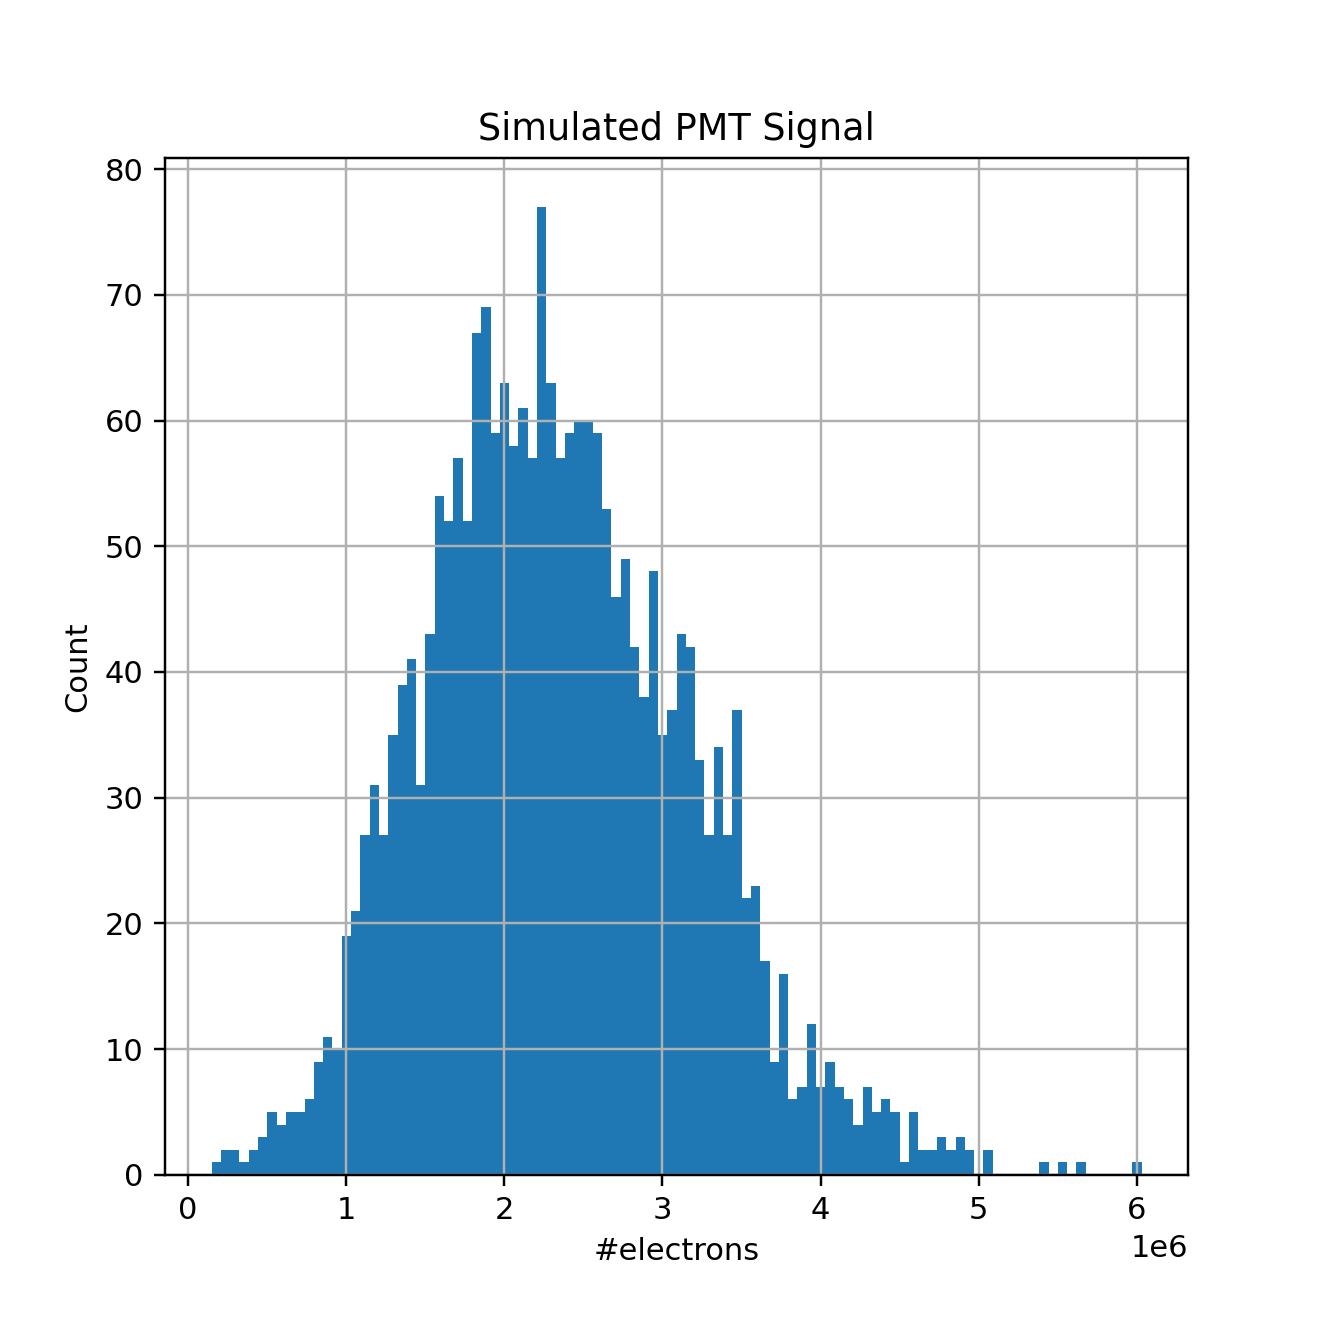

In [248]:
print("Dynode Voltages =", V)
fig1, ax1 = plt.subplots(figsize=(6,6))
counts1, bins1 = np.histogram(pmtSignal, bins=40)
logbins1 = np.logspace(np.log10(bins1[0]),np.log10(bins1[-1]),len(bins1))
ax1.hist(pmtSignal, bins=100)
ax1.set_title('Simulated PMT Signal')
ax1.set_ylabel('Count')
ax1.set_xlabel('#electrons')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.grid(True)
plt.show()